## LLaMA3 almost from scratch

inference only (next token prediction forward pass - no sampling)

inspo from [here](https://github.com/naklecha/llama3-from-scratch/blob/main/llama3-from-scratch.ipynb) however quite a few changes:

* path to model weights via env var
* wip: supports hf weights
* manual embeddings instead of `torch.nn.Embedding`
* variable naming more in line with llama3 impl
* works with arbitrary length of input prompt (og impl has hardcoded dim lengths sometimes)
* model visualization via summary + torchview
* wip: compute the rope embeddings without polar / complex magic
* wip: compute the rope embeddings without "Computational efficient realization of rotary matrix multiplication" from paper and compare if impl is oke


In [1]:
"""Load .env vars"""
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

# Warning: These weights are downloaded from official Meta
# sources e.g. accepting TOS and using Meta's download.sh script.
# (doesn't work with huggingface weights yet)
LLAMA_WEIGHTS_PATH = Path(os.getenv("LLAMA_WEIGHTS_PATH"))

### Tokenizer

[https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py](https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py). 

Code taken out of the official LLaMA3 `Tokenizer` class with changed path handling.

In [2]:
import tiktoken
from tiktoken.load import load_tiktoken_bpe

LLAMA_TOKENIZER_PATH = LLAMA_WEIGHTS_PATH / "tokenizer.model"
special_tokens = [
    "<|begin_of_text|>",
    "<|end_of_text|>",
    "<|reserved_special_token_0|>",
    "<|reserved_special_token_1|>",
    "<|reserved_special_token_2|>",
    "<|reserved_special_token_3|>",
    "<|start_header_id|>",
    "<|end_header_id|>",
    "<|reserved_special_token_4|>",
    "<|eot_id|>",  # end of turn
] + [
    f"<|reserved_special_token_{i}|>"
    for i in range(5, 256 - 5)
]
mergeable_ranks = load_tiktoken_bpe(LLAMA_TOKENIZER_PATH.absolute().as_posix())
tokenizer = tiktoken.Encoding(
    name=LLAMA_TOKENIZER_PATH.name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

# sanity check
tokenizer.decode(tokenizer.encode("can i haz a 🦙"))

'can i haz a 🦙'

### Load the model (weights + config)

In [3]:
import json
import torch

with open(LLAMA_WEIGHTS_PATH / "params.json", "r") as f:
    model_config = json.load(f)
    print(json.dumps(model_config, indent=2))

{
  "dim": 4096,
  "n_layers": 32,
  "n_heads": 32,
  "n_kv_heads": 8,
  "vocab_size": 128256,
  "multiple_of": 1024,
  "ffn_dim_multiplier": 1.3,
  "norm_eps": 1e-05,
  "rope_theta": 500000.0
}


In [4]:
model = torch.load(LLAMA_WEIGHTS_PATH / "consolidated.00.pth")
print(json.dumps(list(model.keys()), indent=2))

[
  "tok_embeddings.weight",
  "layers.0.attention.wq.weight",
  "layers.0.attention.wk.weight",
  "layers.0.attention.wv.weight",
  "layers.0.attention.wo.weight",
  "layers.0.feed_forward.w1.weight",
  "layers.0.feed_forward.w3.weight",
  "layers.0.feed_forward.w2.weight",
  "layers.0.attention_norm.weight",
  "layers.0.ffn_norm.weight",
  "layers.1.attention.wq.weight",
  "layers.1.attention.wk.weight",
  "layers.1.attention.wv.weight",
  "layers.1.attention.wo.weight",
  "layers.1.feed_forward.w1.weight",
  "layers.1.feed_forward.w3.weight",
  "layers.1.feed_forward.w2.weight",
  "layers.1.attention_norm.weight",
  "layers.1.ffn_norm.weight",
  "layers.2.attention.wq.weight",
  "layers.2.attention.wk.weight",
  "layers.2.attention.wv.weight",
  "layers.2.attention.wo.weight",
  "layers.2.feed_forward.w1.weight",
  "layers.2.feed_forward.w3.weight",
  "layers.2.feed_forward.w2.weight",
  "layers.2.attention_norm.weight",
  "layers.2.ffn_norm.weight",
  "layers.3.attention.wq.weight"

### Prepare input prompt

In [5]:
# one forward pass of the model (without sampling) will predict only the next token,
# so the model should predict token id of 'snowing'
input_prompt = "The ground was covered in a blanket of white, so it must have been"
#input_prompt = "the answer to the ultimate question of life, the universe, and everything is "
input_prompt = "No pain no"

# need to manually add beginning of sentence token (128000)
bos_id = tokenizer.encode("<|begin_of_text|>", allowed_special=set(special_tokens))
print(bos_id)

# encode the full input prompt
tokens = bos_id + tokenizer.encode(input_prompt)
print(tokens)

seq_len = len(tokens)
print(seq_len)

[128000]
[128000, 2822, 6784, 912]
4


### OG llama3 visualization

summary taken from [00-llama3-viz.ipynb](./00-llama3-viz.ipynb) (also check that notebook out for a full forward pass computation graph)

(for input tokens of length 16)

<pre>
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Transformer                              [1, 16, 128256]           --
├─Embedding: 1-1                         [1, 16, 4096]             525,336,576
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-1                 [1, 16, 4096]             4,096
│    │    └─Attention: 3-2               [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-3                 [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-4             [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-2             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-5                 [1, 16, 4096]             4,096
│    │    └─Attention: 3-6               [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-7                 [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-8             [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-3             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-9                 [1, 16, 4096]             4,096
│    │    └─Attention: 3-10              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-11                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-12            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-4             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-13                [1, 16, 4096]             4,096
│    │    └─Attention: 3-14              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-15                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-16            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-5             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-17                [1, 16, 4096]             4,096
│    │    └─Attention: 3-18              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-19                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-20            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-6             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-21                [1, 16, 4096]             4,096
│    │    └─Attention: 3-22              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-23                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-24            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-7             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-25                [1, 16, 4096]             4,096
│    │    └─Attention: 3-26              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-27                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-28            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-8             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-29                [1, 16, 4096]             4,096
│    │    └─Attention: 3-30              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-31                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-32            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-9             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-33                [1, 16, 4096]             4,096
│    │    └─Attention: 3-34              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-35                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-36            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-10            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-37                [1, 16, 4096]             4,096
│    │    └─Attention: 3-38              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-39                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-40            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-11            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-41                [1, 16, 4096]             4,096
│    │    └─Attention: 3-42              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-43                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-44            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-12            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-45                [1, 16, 4096]             4,096
│    │    └─Attention: 3-46              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-47                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-48            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-13            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-49                [1, 16, 4096]             4,096
│    │    └─Attention: 3-50              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-51                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-52            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-14            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-53                [1, 16, 4096]             4,096
│    │    └─Attention: 3-54              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-55                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-56            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-15            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-57                [1, 16, 4096]             4,096
│    │    └─Attention: 3-58              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-59                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-60            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-16            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-61                [1, 16, 4096]             4,096
│    │    └─Attention: 3-62              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-63                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-64            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-17            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-65                [1, 16, 4096]             4,096
│    │    └─Attention: 3-66              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-67                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-68            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-18            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-69                [1, 16, 4096]             4,096
│    │    └─Attention: 3-70              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-71                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-72            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-19            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-73                [1, 16, 4096]             4,096
│    │    └─Attention: 3-74              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-75                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-76            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-20            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-77                [1, 16, 4096]             4,096
│    │    └─Attention: 3-78              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-79                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-80            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-21            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-81                [1, 16, 4096]             4,096
│    │    └─Attention: 3-82              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-83                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-84            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-22            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-85                [1, 16, 4096]             4,096
│    │    └─Attention: 3-86              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-87                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-88            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-23            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-89                [1, 16, 4096]             4,096
│    │    └─Attention: 3-90              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-91                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-92            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-24            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-93                [1, 16, 4096]             4,096
│    │    └─Attention: 3-94              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-95                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-96            [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-25            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-97                [1, 16, 4096]             4,096
│    │    └─Attention: 3-98              [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-99                [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-100           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-26            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-101               [1, 16, 4096]             4,096
│    │    └─Attention: 3-102             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-103               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-104           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-27            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-105               [1, 16, 4096]             4,096
│    │    └─Attention: 3-106             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-107               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-108           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-28            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-109               [1, 16, 4096]             4,096
│    │    └─Attention: 3-110             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-111               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-112           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-29            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-113               [1, 16, 4096]             4,096
│    │    └─Attention: 3-114             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-115               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-116           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-30            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-117               [1, 16, 4096]             4,096
│    │    └─Attention: 3-118             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-119               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-120           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-31            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-121               [1, 16, 4096]             4,096
│    │    └─Attention: 3-122             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-123               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-124           [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-32            [1, 16, 4096]             --
│    │    └─RMSNorm: 3-125               [1, 16, 4096]             4,096
│    │    └─Attention: 3-126             [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-127               [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-128           [1, 16, 4096]             176,160,768
├─RMSNorm: 1-3                           [1, 16, 4096]             4,096
├─Linear: 1-4                            [1, 16, 128256]           525,336,576
==========================================================================================
Total params: 8,030,261,248
Trainable params: 8,030,261,248
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.03
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 113.59
Params size (MB): 16060.52
Estimated Total Size (MB): 16174.11
==========================================================================================
</pre>

### Embeddings

In [6]:
import torch.nn as nn

# can add .unsqueeze(0) to input_tensor to make it batched...
input_tensor = torch.tensor(tokens, dtype=torch.long)
token_embeddings_weights = model["tok_embeddings.weight"]
print(input_tensor.shape, token_embeddings_weights.shape)

# embedding layer manually (matmul . one-hot)
one_hot = nn.functional.one_hot(input_tensor, num_classes=model_config["vocab_size"]).bfloat16()
token_embeddings = torch.matmul(one_hot, model["tok_embeddings.weight"])

print("Resulting shape: ", token_embeddings.shape)

torch.Size([4]) torch.Size([128256, 4096])
Resulting shape:  torch.Size([4, 4096])


### RMSNorm

Zhang, B., & Sennrich, R. (2019). [Root Mean Square Layer Normalization.](https://arxiv.org/abs/1910.07467) ArXiv, abs/1910.07467.

In [7]:
def rms_norm(tensor, g, norm_eps):
    return tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps) * g

token_embeddings_normalized = rms_norm(token_embeddings, model["layers.0.attention_norm.weight"], model_config["norm_eps"])

assert token_embeddings_normalized.shape == token_embeddings.shape

### Transformer layer

In [8]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


the attention weights are bundled together along the head dimension [4096, 4096], need to separate them out

into `n_heads=32` heads ([32, 128, 4096])

In [9]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // model_config["n_heads"]
q_layer0 = q_layer0.view(model_config["n_heads"], head_dim, model_config["dim"])
q_layer0.shape

torch.Size([32, 128, 4096])

each head is now a query weight matrix i.e. $W_0^Q$

In [10]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

#### Query per token

16 queries (one per token) of length 128

In [11]:
q_layer0_head0_per_token = torch.matmul(token_embeddings_normalized, q_layer0_head0.T)
q_layer0_head0_per_token.shape

torch.Size([4, 128])

#### Positional encoding (RoPE)

Implemented in:
* [llama3/llama/model.py (L49-75)](https://github.com/meta-llama/llama3/blob/bf8d18cd087a4a0b3f61075b7de0b86cf6c70697/llama/model.py#L49-L75)

In [12]:
q_layer0_head0_per_token_pairs = q_layer0_head0_per_token.view(q_layer0_head0_per_token.shape[0], -1, 2)
q_layer0_head0_per_token_pairs.shape

torch.Size([4, 64, 2])

In [13]:
# dimension of size head_dim // 2 because we created pairs
dim = head_dim // 2
zero_to_one_split_into_half_dim_parts = torch.linspace(0, (dim - 1) / dim, dim)
print(zero_to_one_split_into_half_dim_parts)

freqs = 1.0 / (model_config["rope_theta"] ** zero_to_one_split_into_half_dim_parts)
print(freqs.shape)

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])
torch.Size([64])


torch.Size([4, 64])


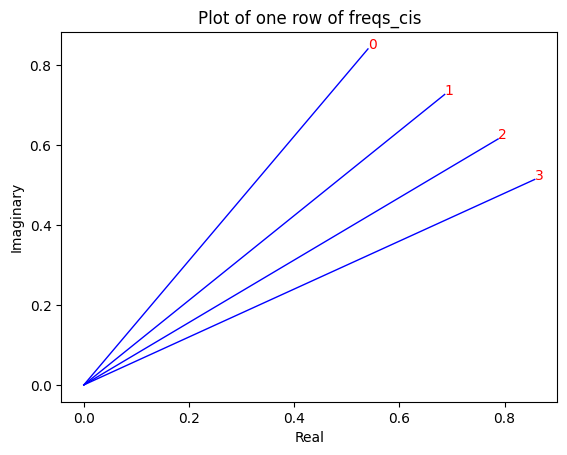

In [14]:
import matplotlib.pyplot as plt

freqs_for_each_token = torch.outer(torch.arange(seq_len), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
print(freqs_cis.shape)

# viewing tjhe third row of freqs_cis
value = freqs_cis[1]
plt.figure()
for i, element in enumerate(value[:seq_len]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

update query to complex numbers so that we can matmul with `freqs_cis`

In [15]:
q_layer0_head0_per_token_pairs_complex = torch.view_as_complex(q_layer0_head0_per_token_pairs.float())
q_layer0_head0_per_token_pairs_complex.shape

torch.Size([4, 64])

In [16]:
q_layer0_head0_per_token_pairs_complex_rotated = q_layer0_head0_per_token_pairs_complex * freqs_cis
q_layer0_head0_per_token_pairs_complex_rotated.shape

torch.Size([4, 64])

In [17]:
q_layer0_head0_per_token_pairs_rotated = torch.view_as_real(q_layer0_head0_per_token_pairs_complex_rotated)
q_layer0_head0_per_token_pairs_rotated.shape

torch.Size([4, 64, 2])

rotated pairs are now merged (rope applied on the original **query** vector)

In [18]:
q_layer0_head0_per_token_rotated = q_layer0_head0_per_token_pairs_rotated.view(q_layer0_head0_per_token.shape)
q_layer0_head0_per_token_rotated.shape

torch.Size([4, 128])

need to do the same for **keys**

In [19]:
k_layer0 = model["layers.0.attention.wk.weight"]
kv_dim = k_layer0.shape[0] // model_config["n_kv_heads"]
k_layer0 = k_layer0.view(model_config["n_kv_heads"], kv_dim, model_config["dim"])
k_layer0.shape

torch.Size([8, 128, 4096])

In [20]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [21]:
k_layer0_head0_per_token = torch.matmul(token_embeddings_normalized, k_layer0_head0.T)
k_layer0_head0_per_token.shape

torch.Size([4, 128])

In [22]:
k_layer0_head0_per_token_pairs = k_layer0_head0_per_token.view(k_layer0_head0_per_token.shape[0], -1, 2)
k_layer0_head0_per_token_pairs.shape

torch.Size([4, 64, 2])

In [23]:
k_layer0_head0_per_token_pairs_complex = torch.view_as_complex(k_layer0_head0_per_token_pairs.float())
k_layer0_head0_per_token_pairs_complex.shape

torch.Size([4, 64])

In [24]:
k_layer0_head0_per_token_pairs_complex_rotated = k_layer0_head0_per_token_pairs_complex * freqs_cis
k_layer0_head0_per_token_pairs_complex_rotated.shape

torch.Size([4, 64])

In [25]:
k_layer0_head0_per_token_pairs_rotated = torch.view_as_real(k_layer0_head0_per_token_pairs_complex_rotated)
k_layer0_head0_per_token_pairs_rotated.shape

torch.Size([4, 64, 2])

In [26]:
k_layer0_head0_per_token_rotated = k_layer0_head0_per_token_pairs_rotated.view(k_layer0_head0_per_token.shape)
k_layer0_head0_per_token_rotated.shape

torch.Size([4, 128])

have: queries $Q$ and keys $K$ in shape [16, 128] in the first layer, 0th head

we will use it to compute **masked self-attention**:

$$Z = \text{softmax}(\frac{Q \cdot K^T}{\sqrt{d_k}}) \cdot V$$

but first, the unmasked self-attention matrix $Q \cdot K^T$ of shape [16, 16] which is [input_size, input_size]:

In [27]:
qk_layer0_head0_per_token = torch.matmul(q_layer0_head0_per_token_rotated, k_layer0_head0_per_token_rotated.T)
qk_layer0_head0_per_token.shape

torch.Size([4, 4])

#### Self-attention mask

forward masking of $QK^T$ (for self-attention):

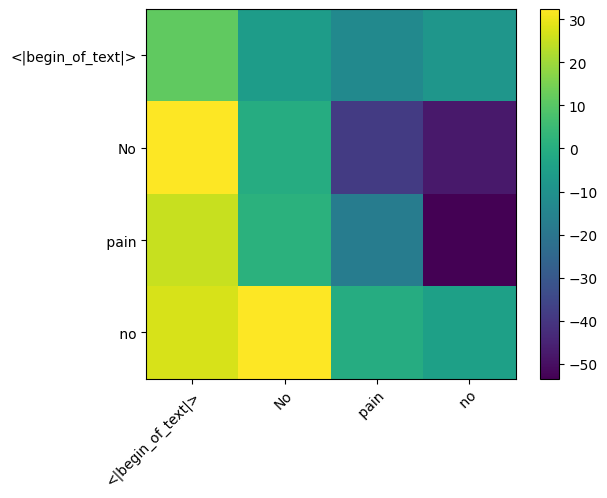

In [28]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in input_tensor]
    ax.set_xticklabels(prompt_split_as_tokens, rotation_mode="anchor", rotation=45, ha="right")
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_layer0_head0_per_token)

In [29]:
mask = torch.full((seq_len, seq_len), float("-inf"))
mask = torch.triu(mask, diagonal=1)
print(mask)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])


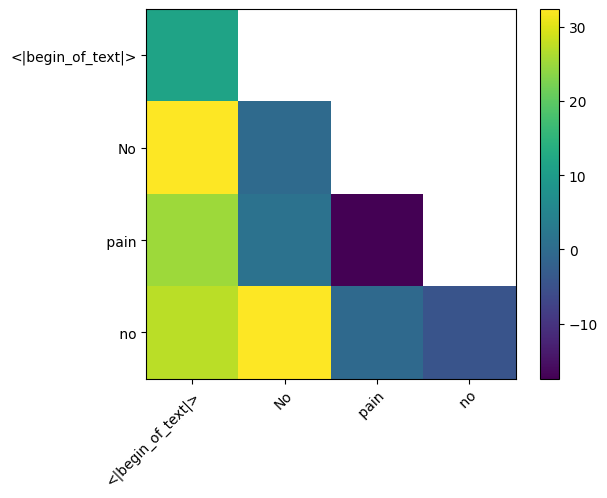

In [30]:
qk_layer0_head0_per_token_masked = qk_layer0_head0_per_token + mask
display_qk_heatmap(qk_layer0_head0_per_token_masked)

apply softmax on attention

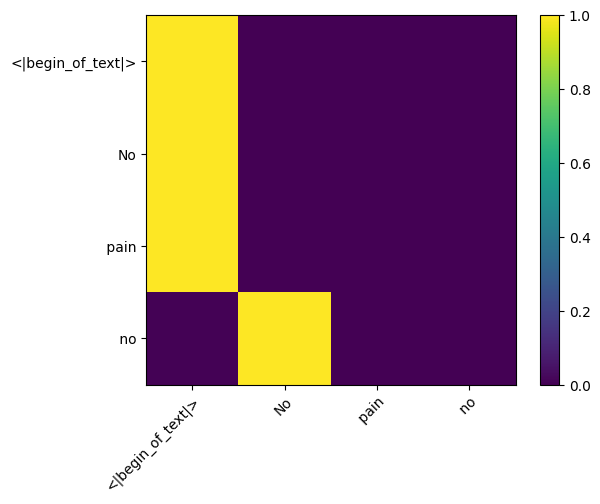

In [31]:
qk_layer0_head0_per_token_softmax = nn.functional.softmax(qk_layer0_head0_per_token_masked, dim=-1).bfloat16()
display_qk_heatmap(qk_layer0_head0_per_token_softmax)

#### Values $V$

In [32]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(model_config["n_kv_heads"], v_layer0.shape[0] // model_config["n_kv_heads"], model_config["dim"])
v_layer0.shape

torch.Size([8, 128, 4096])

In [33]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [34]:
v_per_token = torch.matmul(token_embeddings_normalized, v_layer0_head0.T)
v_per_token.shape

torch.Size([4, 128])

attention

In [35]:
qkv_attention = torch.matmul(qk_layer0_head0_per_token_softmax, v_per_token)
qkv_attention.shape

torch.Size([4, 128])

#### Multi-head attention in layer0

In [36]:
qkv_attention_store = []

for head in range(model_config["n_heads"]):
    q_layer0_head = q_layer0[head]
    # keys and values are shared across 4 heads
    k_layer0_head = k_layer0[head // 4]
    v_layer0_head = v_layer0[head // 4]

    q_layer0_head_per_token = torch.matmul(token_embeddings_normalized, q_layer0_head.T)
    k_layer0_head_per_token = torch.matmul(token_embeddings_normalized, k_layer0_head.T)
    v_layer0_head_per_token = torch.matmul(token_embeddings_normalized, v_layer0_head.T)

    q_layer0_per_token_pairs = q_layer0_head_per_token.view(q_layer0_head_per_token.shape[0], -1, 2)
    q_layer0_per_token_pairs_complex = torch.view_as_complex(q_layer0_per_token_pairs.float())
    q_layer0_per_token_pairs_rotated = torch.view_as_real(q_layer0_per_token_pairs_complex * freqs_cis)
    q_layer0_rotated = q_layer0_per_token_pairs_rotated.view(q_layer0_head_per_token.shape)

    k_layer0_per_token_pairs = k_layer0_head_per_token.view(k_layer0_head_per_token.shape[0], -1, 2)
    k_layer0_per_token_pairs_complex = torch.view_as_complex(k_layer0_per_token_pairs.float())
    k_layer0_per_token_pairs_rotated = torch.view_as_real(k_layer0_per_token_pairs_complex * freqs_cis)
    k_layer0_rotated = k_layer0_per_token_pairs_rotated.view(k_layer0_head_per_token.shape)

    qk_per_token = torch.matmul(q_layer0_rotated, k_layer0_rotated.T) / (model_config["dim"] // model_config["n_heads"]) ** 0.5
    mask = torch.full((seq_len, seq_len), float("-inf"))
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_masked = qk_per_token + mask
    qk_per_token_softmax = nn.functional.softmax(qk_per_token_masked, dim=-1).bfloat16()

    qkv_attention = torch.matmul(qk_per_token_softmax, v_layer0_head_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

#### concat all attention matrices

32 rows of 16x128 inside qkv_attention_store

In [37]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([4, 4096])

multiply with final weight matrix (linear layer)

In [38]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

In [39]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([4, 4096])

In [40]:
embedding_after_edit = token_embeddings + embedding_delta
embedding_after_edit.shape

torch.Size([4, 4096])

In [41]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"], model_config["norm_eps"])
embedding_after_edit_normalized.shape

torch.Size([4, 4096])

#### FF SwiGLU at the top of a transformer block

In [42]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(
    torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T),
    w2.T
)
output_after_feedforward.shape

torch.Size([4, 4096])

In [43]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([4, 4096])

### full model forward pass (everything at once)

In [44]:
model_config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [45]:
final_embedding = token_embeddings

for layer in range(model_config["n_layers"]):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"], model_config["norm_eps"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(model_config["n_heads"], q_layer.shape[0] // model_config["n_heads"], model_config["dim"])
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(model_config["n_kv_heads"], k_layer.shape[0] // model_config["n_kv_heads"], model_config["dim"])
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(model_config["n_kv_heads"], v_layer.shape[0] // model_config["n_kv_heads"], model_config["dim"])

    for head in range(model_config["n_heads"]):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head // 4]
        v_layer_head = v_layer[head // 4]

        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_pairs = q_per_token.view(q_per_token.shape[0], -1, 2)
        q_per_token_pairs_complex = torch.view_as_complex(q_per_token_pairs.float())
        q_per_token_pairs_rotated = torch.view_as_real(q_per_token_pairs_complex * freqs_cis)
        q_rotated = q_per_token_pairs_rotated.view(q_per_token.shape)
        k_per_token_pairs = k_per_token.view(k_per_token.shape[0], -1, 2)
        k_per_token_pairs_complex = torch.view_as_complex(k_per_token_pairs.float())
        k_per_token_pairs_rotated = torch.view_as_real(k_per_token_pairs_complex * freqs_cis)
        k_rotated = k_per_token_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_rotated, k_rotated.T) / (model_config["dim"] // model_config["n_heads"]) ** 0.5
        mask = torch.full((seq_len, seq_len), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_masked = qk_per_token + mask
        qk_per_token_softmax = nn.functional.softmax(qk_per_token_masked, dim=-1).bfloat16()
        qkv_attention = torch.matmul(qk_per_token_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"], model_config["norm_eps"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(
        torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T),
        w2.T
    )
    final_embedding = embedding_after_edit+output_after_feedforward

final_embedding = rms_norm(final_embedding, model["norm.weight"], model_config["norm_eps"])
final_embedding.shape

torch.Size([4, 4096])

#### decode the final embedding to token value

In [46]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [47]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(8895)

In [48]:
tokenizer.decode([next_token.item()])

' gain'